<a href="https://colab.research.google.com/github/jhChoi1997/EE488_AI_Convergence_Capstone_Design_Anomaly_Detection_2022spring/blob/main/Experiment2/Corrupted_MNIST_FrontEnd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EE 488 AI Convergence Capstone Design : Anomaly Detection**

## **practice 2-2 : Importance of Front end system and Data Augmentation**

### **Corrupted case**

When given dataset is noisy, front end system can be applied to model.

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, TensorDataset
from sklearn import metrics
import matplotlib.pyplot as plt
import torchsummary
import numpy as np

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [ ]:
plt.rc('font', size=20)

In [ ]:
EPOCHS = 100
BATCH = 32
ANOMALY_NUM = 9

In [ ]:
mnist_train = datasets.MNIST(root='MNIST_data/', train=True, transform=ToTensor(), download=True)
mnist_test = datasets.MNIST(root='MNIST_data/', train=False, transform=ToTensor(), download=True)

train_x = torch.tensor([mnist_train[i][0].numpy() for i, v in enumerate(mnist_train) if v[1] != ANOMALY_NUM])
# add noise
train_x = torch.min(torch.tensor(1),train_x + torch.abs(torch.normal(0,1,size=train_x.shape)))
train_num = torch.tensor([mnist_train[i][1] for i, v in enumerate(mnist_train) if v[1] != ANOMALY_NUM])
train_num_oh = F.one_hot(train_num)

unseen_x = torch.tensor([v[0].numpy() for v in mnist_test])
# add noise
unseen_x = torch.min(torch.tensor(1),unseen_x + torch.abs(torch.normal(0,1,size=unseen_x.shape)))
unseen_num = torch.tensor([v[1] for v in mnist_test])
unseen_y = torch.tensor([0 if v[1] != ANOMALY_NUM else 1 for v in mnist_test])


val_x = unseen_x[:int(len(unseen_x) / 2)]
val_num = unseen_num[:int(len(unseen_x) / 2)]
val_num_oh = F.one_hot(val_num)
val_num_oh = torch.cat((val_num_oh[:,0:ANOMALY_NUM],val_num_oh[:,ANOMALY_NUM+1:]), dim=1)
val_y = unseen_y[:int(len(unseen_y) / 2)]

test_x = unseen_x[int(len(unseen_x) / 2):]
test_num = unseen_num[int(len(unseen_x) / 2):]
test_num_oh = F.one_hot(test_num)
test_num_oh = torch.cat((test_num_oh[:,0:ANOMALY_NUM],test_num_oh[:,ANOMALY_NUM+1:]), dim=1)
test_y = unseen_y[int(len(unseen_y) / 2):]

train_dataset = TensorDataset(train_x, train_num_oh)
val_dataset = TensorDataset(val_x, val_num_oh, val_y)
test_dataset = TensorDataset(test_x, test_num_oh, test_y)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  after removing the cwd from sys.path.


In [ ]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

54051
5000
5000


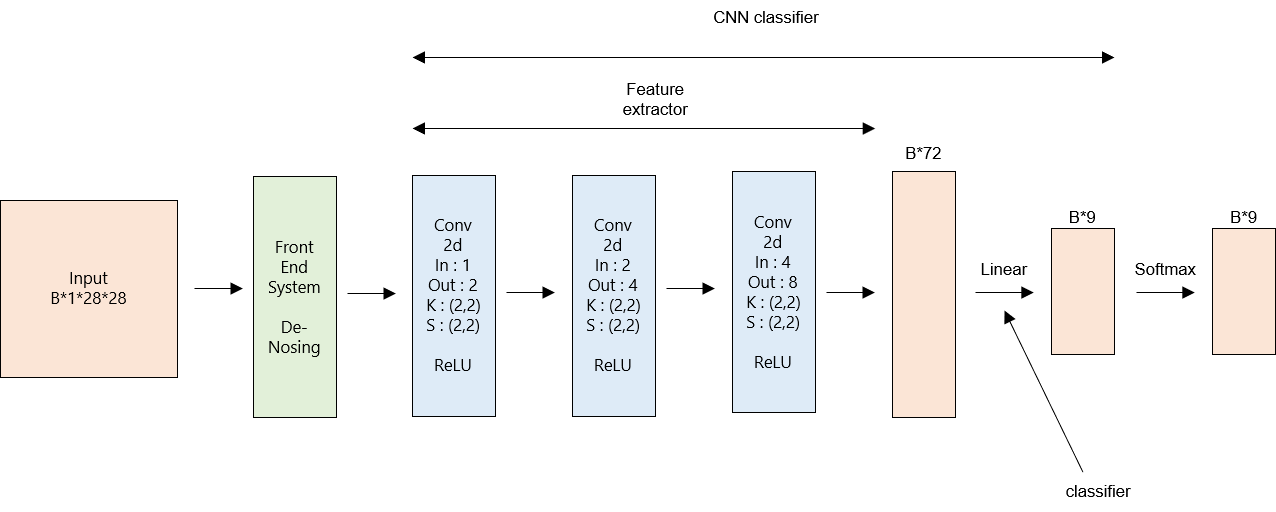

In [ ]:
class ClassificationCNNModel(nn.Module):
    def __init__(self):
        super(ClassificationCNNModel, self).__init__()
        self.sm_weight = torch.tensor([[1/64,1/64,1/64,1/64,1/64],[1/64,1/32,1/32,1/32,1/64],[1/64,1/32,1/2,1/32,1/64],[1/64,1/32,1/32,1/32,1/64],[1/64,1/64,1/64,1/64,1/64]]).view(1,1,5,5).to(device)

        
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1,2,kernel_size = (2,2), stride = (2,2)),
            nn.ReLU(),
            nn.Conv2d(2,4,kernel_size = (2,2), stride = (2,2)),
            nn.ReLU(),
            nn.Conv2d(4,8,kernel_size = (2,2), stride = (2,2)),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(72,9)
        )

    def forward(self, x):
        mask = F.conv2d(x, self.sm_weight, padding=2)
        out = x*(mask>0.7).float()
        out = self.feature_extractor(x)
        out = out.reshape(out.shape[0],-1)
        out = self.classifier(out)
        return out

In [ ]:
model = ClassificationCNNModel().to(device)
print(model)

ClassificationCNNModel(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 2, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(2, 4, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(4, 8, kernel_size=(2, 2), stride=(2, 2))
    (5): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=72, out_features=9, bias=True)
  )
)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
def anomaly_score(logits):
    prob = torch.softmax(logits, dim=1)
    MSP = torch.max(prob, dim=1).values
    return torch.tensor(1) - MSP
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    losses = []
    for batch, y in enumerate(dataloader):
        
        pred = model(y[0].to(device))


        loss = loss_fn(pred, y[1].to(device).float())
        

        for idata in range(pred.shape[0]):

            iloss = loss_fn(pred[idata:idata+1,:], y[1][idata:idata+1,:].to(device).float())
            losses.append(iloss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 300 == 0:
            loss, current = loss.item(), batch * pred.shape[0]
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


    return np.mean(losses)

In [ ]:
def test(dataloader, model, loss_fn, anomaly_score, draw_mode = False):
    model.eval()

    y_true, y_pred = [], []

    normal_loss = []
    normal_scores = []
    anomaly_scores  =[]

    with torch.no_grad():
      
        for batch, num, anomaly in dataloader:

            batch = batch.to(device)

            num = num.to(device)
            anomaly = anomaly.to(device)
            output = model(batch)

            for idata in range(output.shape[0]):

                iloss = loss_fn(output[idata:idata+1,:], num[idata:idata+1,:].to(device).float())
                iscore = anomaly_score(output[idata:idata+1,:])
                if anomaly[idata] == 0:
                    normal_loss.append(iloss)
                    normal_scores.append(iscore)
                elif anomaly[idata] == 1:
                    anomaly_scores.append(iscore)


            score = anomaly_score(output)

            y_true.extend(anomaly.tolist())
            y_pred.extend(score.tolist())

    roc_auc = metrics.roc_auc_score(y_true, y_pred)

    if draw_mode:
        fpr, tpr, _ = metrics.roc_curve(y_true,y_pred)
        plt.figure(figsize=(10,10))
        plt.plot(fpr,tpr)
        plt.title('ROC curve')
        plt.xlabel('FPR')
        plt.ylabel('TPR')


    print(f'AUC: {roc_auc:>0.3f}')
    normal_loss = [i.item() for i in normal_loss]
    normal_scores = [i.item() for i in normal_scores]
    anomaly_scores = [i.item() for i in anomaly_scores]

    normal_loss_mean = np.mean(normal_loss)
    normal_score_mean = np.mean(normal_scores)
    anomaly_score_mean = np.mean(anomaly_scores)

    print(f'normal loss : {normal_loss_mean}')

    return roc_auc.item(), normal_loss_mean, normal_score_mean, anomaly_score_mean, normal_scores, anomaly_scores

In [ ]:
train_losses = []
val_normal_losses= []
val_normal_scores = []
val_anomaly_scores = []
roc_auc = []

best_auc = 0.0
best_model = model.to(device)

for t in range(EPOCHS):
    print(f"Epoch {t + 1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    auc,val_normal_loss, val_normal_score, val_anomaly_score, _, _ = test(val_dataloader, model, loss_fn, anomaly_score)

    train_losses.append(train_loss)
    val_normal_losses.append(val_normal_loss)
    val_normal_scores.append(val_normal_score)
    val_anomaly_scores.append(val_anomaly_score)

    roc_auc.append(auc)

    if auc > best_auc:
        best_model, best_auc = model, auc

Epoch 1
-------------------------------
loss: 2.214591  [    0/54051]
loss: 1.454621  [ 9600/54051]
loss: 1.226889  [19200/54051]
loss: 0.809760  [28800/54051]
loss: 1.021056  [38400/54051]
loss: 0.538978  [48000/54051]
AUC: 0.618
normal loss : 0.8748869002168167
Epoch 2
-------------------------------
loss: 0.985618  [    0/54051]
loss: 0.682943  [ 9600/54051]
loss: 0.843243  [19200/54051]
loss: 0.583407  [28800/54051]
loss: 0.870593  [38400/54051]
loss: 0.500934  [48000/54051]
AUC: 0.647
normal loss : 0.7354309571375081
Epoch 3
-------------------------------
loss: 0.886868  [    0/54051]
loss: 0.495657  [ 9600/54051]
loss: 0.776325  [19200/54051]
loss: 0.491301  [28800/54051]
loss: 0.867909  [38400/54051]
loss: 0.500110  [48000/54051]
AUC: 0.670
normal loss : 0.691289184546024
Epoch 4
-------------------------------
loss: 0.868319  [    0/54051]
loss: 0.432364  [ 9600/54051]
loss: 0.713771  [19200/54051]
loss: 0.452642  [28800/54051]
loss: 0.806171  [38400/54051]
loss: 0.482595  [48

<Figure size 432x288 with 0 Axes>

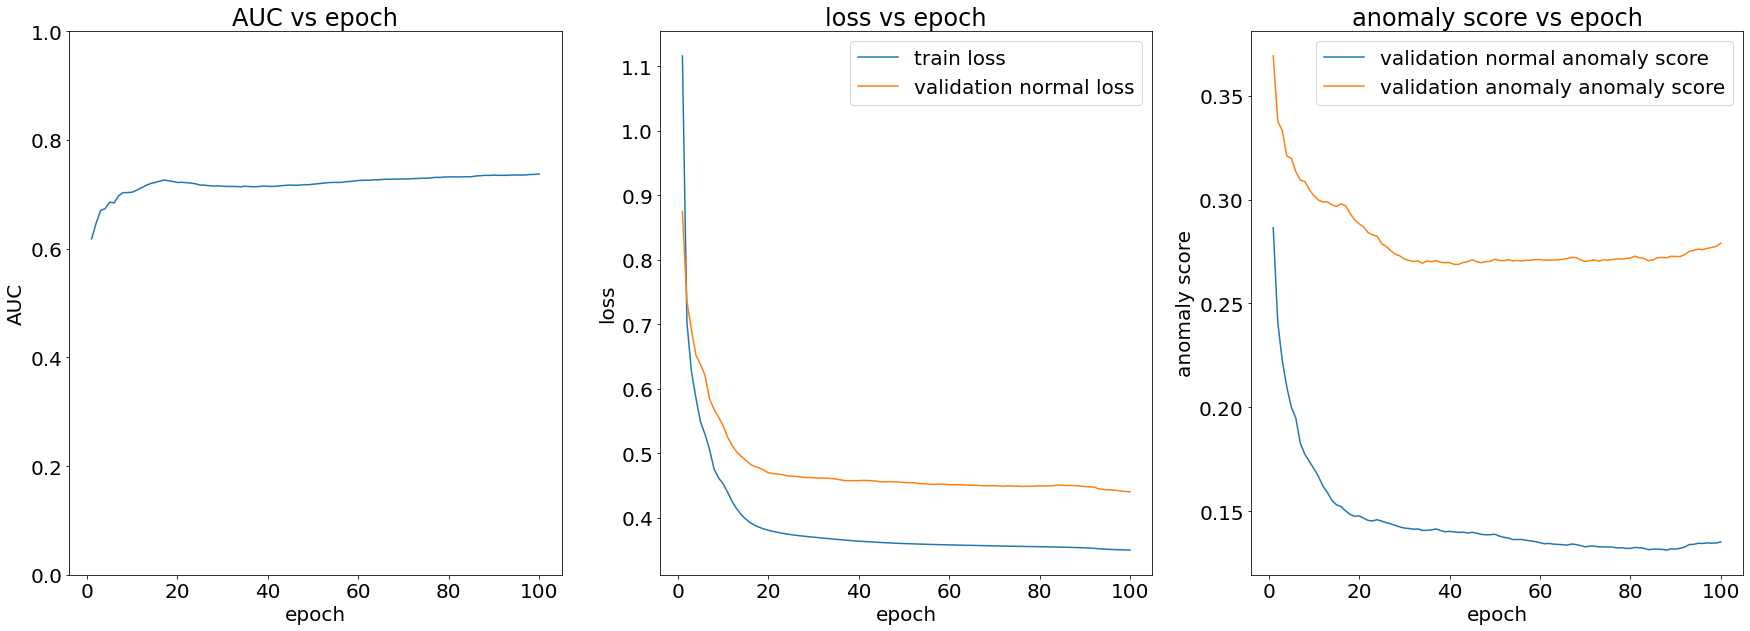

In [ ]:
plt.clf()
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.plot(list(range(1,len(roc_auc)+1)),roc_auc)
plt.xlabel('epoch')
plt.ylabel('AUC')
plt.title('AUC vs epoch')
plt.ylim([0, 1])

plt.subplot(1,3,2)
plt.plot(list(range(1,len(train_losses)+1)),train_losses)
plt.plot(list(range(1,len(val_normal_losses)+1)),val_normal_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss vs epoch')
plt.legend(['train loss', 'validation normal loss'])

plt.subplot(1,3,3)
plt.plot(list(range(1,len(val_normal_scores)+1)),val_normal_scores)
plt.plot(list(range(1,len(val_anomaly_scores)+1)),val_anomaly_scores)
plt.xlabel('epoch')
plt.ylabel('anomaly score')
plt.title('anomaly score vs epoch')
plt.legend(['validation normal anomaly score','validation anomaly anomaly score'])

AUC: 0.811
normal loss : 0.229340879094357


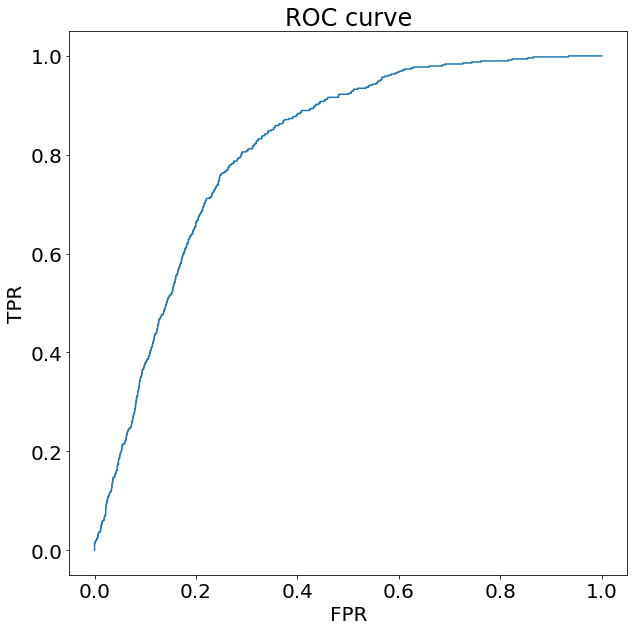

In [ ]:
test_auc,test_normal_loss, test_normal_score, test_anomaly_score, test_normal_scores, test_anomaly_scores = test(test_dataloader, best_model, loss_fn, anomaly_score, draw_mode=True)

<Figure size 720x720 with 0 Axes>

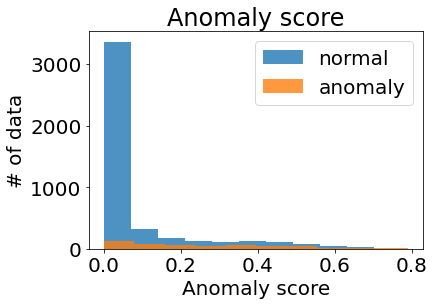

<Figure size 720x720 with 0 Axes>

In [ ]:
plt.hist(test_normal_scores, alpha = 0.8)
plt.hist(test_anomaly_scores, alpha = 0.8)
plt.title('Anomaly score')
plt.xlabel('Anomaly score')
plt.ylabel('# of data')
plt.legend(['normal','anomaly'])
plt.figure(figsize=(10,10))

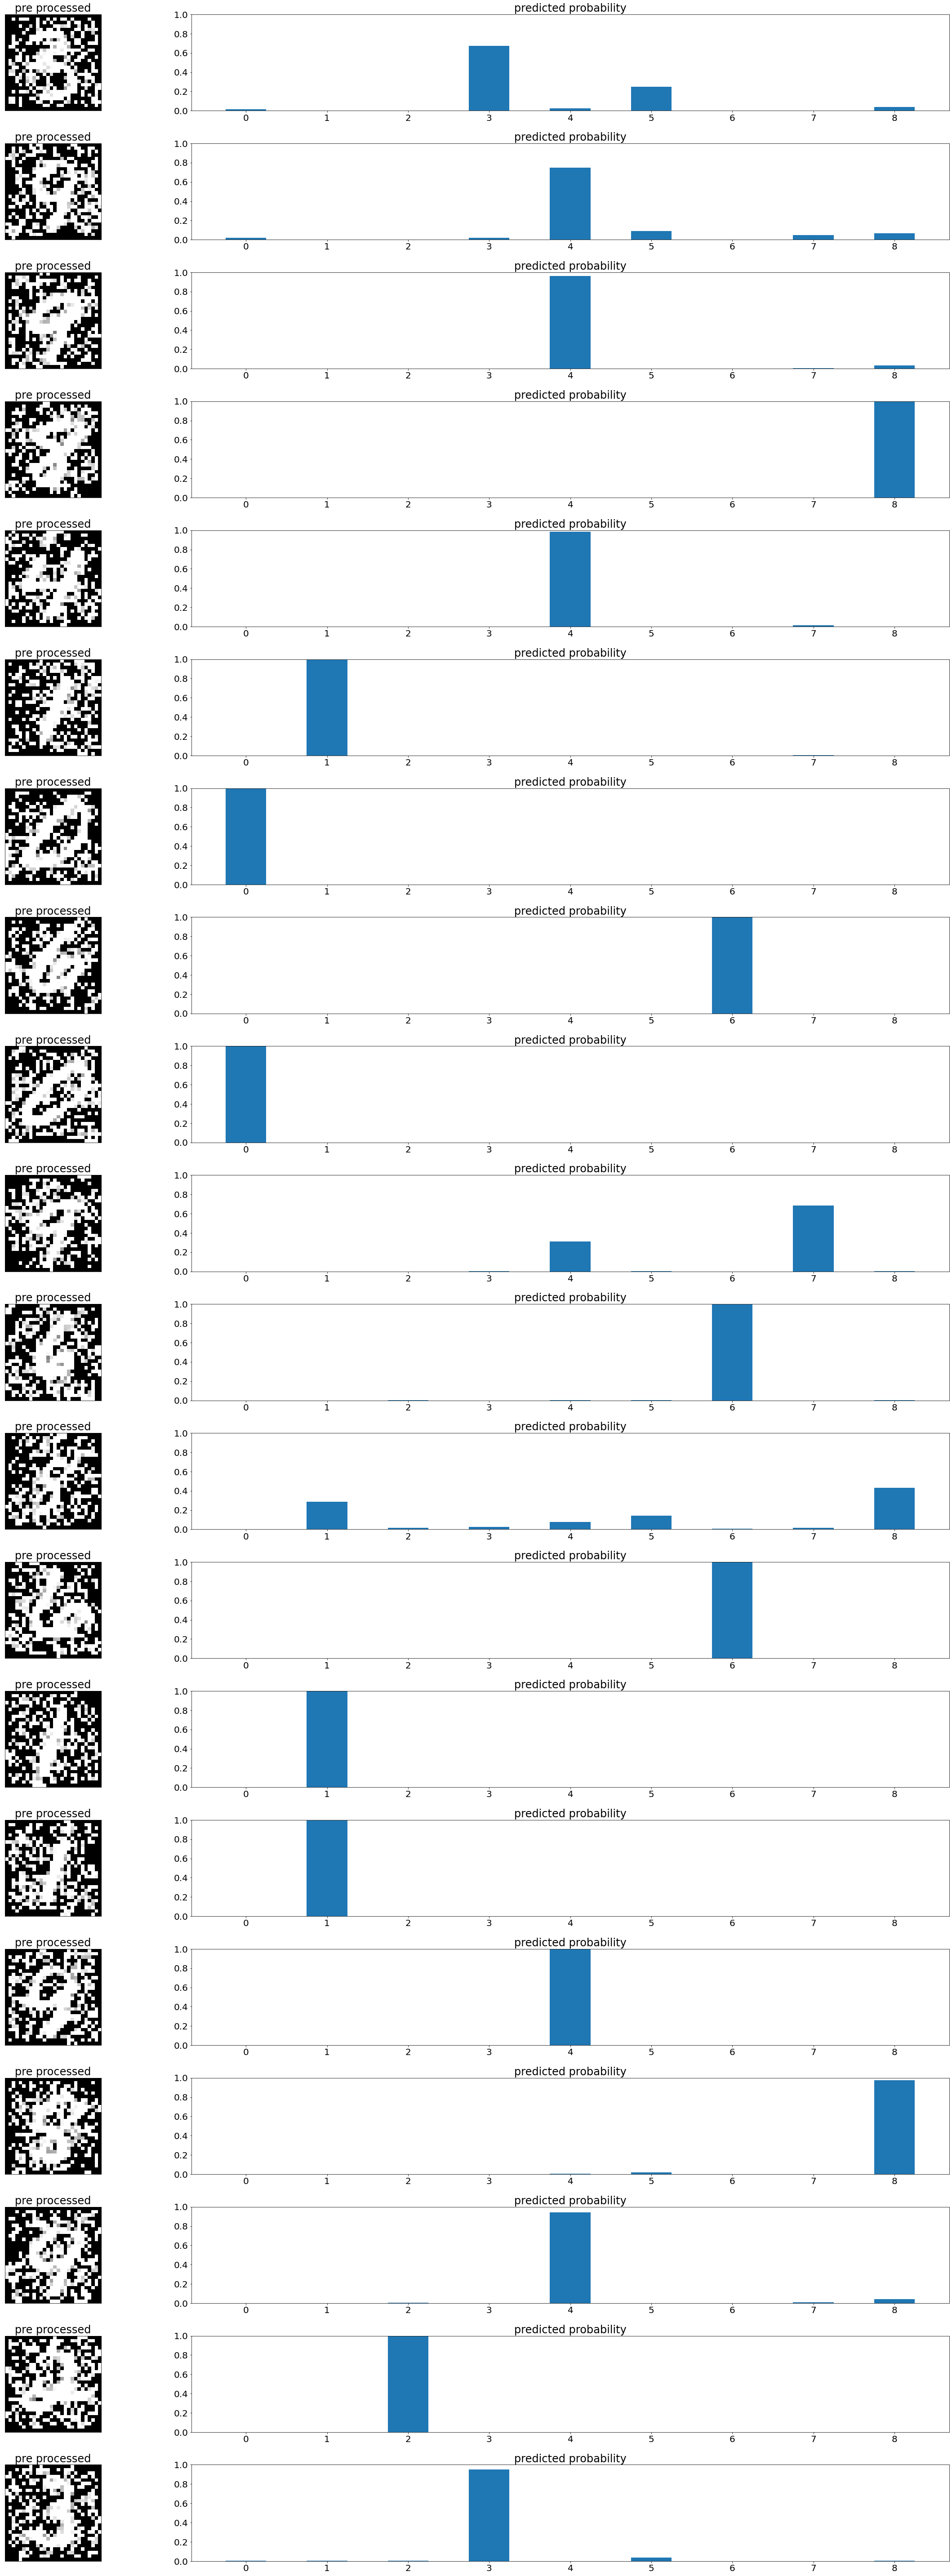

In [ ]:
n = 20
plt.figure(figsize=(40, 80))

for i in range(n):
    input_image = test_dataset[i][0].to(device)
    pred_prob = torch.softmax(best_model(input_image.unsqueeze(0)),dim=1).cpu().detach().squeeze().numpy()
    
    filter = torch.tensor([[1/64,1/64,1/64,1/64,1/64],[1/64,1/32,1/32,1/32,1/64],[1/64,1/32,1/2,1/32,1/64],[1/64,1/32,1/32,1/32,1/64],[1/64,1/64,1/64,1/64,1/64]]).view(1,1,5,5).to(device)

    mask = F.conv2d(input_image.view(1,1,28,28), filter, padding=2)
    input_image = input_image*(mask>0.7).float()
    input_image = input_image.squeeze().squeeze()

    ax = plt.subplot(n, 2, 2*i+1)
    plt.imshow(input_image.cpu())
    plt.title('pre processed')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax2 = plt.subplot(n, 2, 2*i+2)
    ax2.set_ylim([0,1])
    classify_as = np.array(list(range(ANOMALY_NUM)) + list(range(ANOMALY_NUM+1,9)))
    plt.bar(classify_as, pred_prob, width = 0.5, tick_label = [str(i) for i in classify_as])
    #plt.imshow(output_image[0].squeeze().detach().cpu())
    plt.title('predicted probability')
    plt.tight_layout()

plt.show()